# Notebook 4: Modélisation supervisée

## 1. Libraries & Settings

In [6]:
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.exceptions import ConvergenceWarning
import nltk
import warnings
import mlflow
import mlflow.sklearn
from tqdm import tqdm
import pickle

nltk.download('punkt', quiet = True)
nltk.download('stopwords',quiet = True)
nltk.download('wordnet', quiet = True)
nltk.download('averaged_perceptron_tagger_eng', quiet = True)

warnings.filterwarnings("ignore", category=UserWarning, message=".*token_pattern.*")
warnings.filterwarnings("ignore", message="The parameter 'token_pattern' will not be used since 'tokenizer' is not None")
warnings.filterwarnings("ignore", category=UserWarning, message=".*looks more like a filename.*")
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.feature_extraction.text')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
pd.set_option('display.max_colwidth', None)

## 2. Load Data

In [7]:
# Load Data
df = pd.read_csv("C:/Users/Luciana/Documents/GitHub/NLP-Multi-Label-Text-Classification-for-Stack-Overflow-Tag-Prediction/QueryResults.csv")

# Drop unnecessary columns
df.drop(columns=['Id', 'Score', 'ViewCount', 'AnswerCount', 'FavoriteCount'], inplace=True) #, 'FavoriteCount'
df = df.sample(frac=0.5, random_state=42)
df.reset_index(drop=True, inplace=True)

## 3. Preprocessing

In [8]:
# Function for cleaning TAGS ---------------------------------------------------------------------
special_words = {'c#', 'c++', 'f#', 'asp.net', 'vb.net', 'node.js', 'objective-c', 'ai'}

# Function for the 'Tags' colum ---------------------------------------------------------------------
def preprocess_tags(tags):
    def clean_word(word):        
        if word in special_words: # Preserve special words exactly
            return word        
        cleaned_word = re.sub(r"[^\w\s\-]", "", word) # Remove unwanted characters except hyphen, apostrophe        
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word) # Remove trailing hyphens or numbers
        if re.search(r"\d", cleaned_word):  # Remove words containing any number
            return ""
        return cleaned_word    
        
    words = re.findall(r'(?<=<)(.*?)(?=>)', tags)  # Extract words
    processed_words = [
        clean_word(word) for word in words] # Keep words within length constraints 
    words = [subword for word in processed_words for subword in word.split()]  
    words = [w for w in words if len(w) > 2 or w in special_words] 
    return words

# Function for cleaning BODY & TITLE ---------------------------------------------------------------------
def clean_text(sentence):
    def clean_word(word):
        if word in special_words:  # Preserve special words exactly
            return [word]        
        cleaned_word = re.sub(r"(\'s|\'ve|\'d|\'ll|\'re|\'m|\'t)$", "", word) # Remove common contraction suffixes        
        cleaned_word = re.sub(r"[^\w\s\-]", " ", cleaned_word)  # Replace non-alphanumeric characters (except hyphens) with spaces
        cleaned_word = re.sub(r"^-+", "", cleaned_word)  # Remove leading hyphens
        cleaned_word = re.sub(r"[-\d]+$", "", cleaned_word)  # Remove trailing hyphens or numbers
        cleaned_word = cleaned_word.strip()
        
        if len(cleaned_word) <= 1 and cleaned_word not in special_words: # remove any single-letter words after cleaning
            return None        
        split_words = re.split(r'[.\-#]', cleaned_word) # Split words like 'this.opacity' into 'this' and 'opacity'        
        split_words = [sub_word for word in split_words for sub_word in word.split() if sub_word] # additional split on spaces in case of unexpected grouping        
        return [w for w in split_words if w] # Remove empty strings from the split result
    
    soup = BeautifulSoup(sentence, "html.parser") # Remove HTML tags and convert to lowercase
    sentence = soup.get_text()
    sentence = sentence.lower()    
    words = sentence.split()     
    words = re.findall(r"\w+[-.#']?\w*|\S+", sentence) # Tokenize words 
    
    processed_words = [clean_word(word) for word in words] # Process and filter words
    filtered_words = [
        word for sublist in processed_words if sublist for word in sublist
        if len(word) > 1  # Exclude single-letter words
        and '_' not in word  # Exclude words with underscores
        and word.isascii()  # Exclude non-ASCII words
        and not any(char.isdigit() for char in word)  ]  # Exclude words with digits
    return filtered_words
    
# STOP WORDS -------------------------------------------------------------------
stop_w = set(stopwords.words('english'))
def stop_word_filter(list_words):
    return [ w for w in list_words if w not in stop_w]

# LEMMA -------------------------------------------------------------------
lemmatizer = WordNetLemmatizer()
def lemma_words(list_words):
    return [lemmatizer.lemmatize(w, pos='v') for w in list_words]

# Remove specific words -------------------------------------------------------------------
words_to_exclude = {'however', 'good', 'anyone', 'say', 'problem','better', 'another', 'please', 'etc', 'actually','someone', 'happen', 'ask',  'maybe', 'look', 'little', 'advance',
'need', 'something', 'question', 'example', 'thank', 'also', 'cannot', 'think', 'anything', 'idea', 'thing', 'ideas', 'people', 'basically', 'nice', 'easily', 'feel',
'obviously', 'specifically', 'problem'}
def remove_words(tokens):
    tagged_tokens = nltk.pos_tag(tokens)
    tags_to_remove = {'MD', 'CD' } # 'WRB', 'WP$', 'PRP$', 'PDT', 'JJR',  'EX'
    return [ word for word, tag in tagged_tokens
        if tag not in tags_to_remove and word.lower() not in words_to_exclude]

# Preprocessing BODY & TITLE ---------------------------------------------------------------------
def custom_tokenizer(desc_text):
    cleaned = clean_text(desc_text)
    filtered = stop_word_filter(cleaned)
    lemmatized = lemma_words(filtered)
    words_removed = remove_words(lemmatized)
    return words_removed
    
# Apply preprocessing
df['Tags'] = df['Tags'].apply(preprocess_tags)
df['title_clean_bow'] = df['Title'].apply(custom_tokenizer)
df['body_clean_bow'] = df['Body'].apply(custom_tokenizer)

# Combine "Title" and "Body" for the Bag of Words approach
df['combined_text_bow'] = df['title_clean_bow'] + df['body_clean_bow']
df['combined_text_bow'] = df['combined_text_bow'].apply(lambda x: ' '.join(x))
X = df['combined_text_bow']

# Truncate the body column to X amount of words
#max_lenght_body = 250
#df['combined_text_bow'] = df['combined_text_bow'].apply(lambda x: x[:max_lenght_body])

# MultiLabelBinarizer for target column
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(df['Tags']), columns=mlb.classes_)
top_tags = y.sum().sort_values(ascending=False).head(100).index
y_top_tags = y[top_tags]
y_top_tags = y_top_tags[y_top_tags.sum(axis=1) > 0]
X_filtered = X.loc[y_top_tags.index]  
y = y_top_tags
y.reset_index(drop=True, inplace=True)
X_filtered.reset_index(drop=True, inplace=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

## 4. TFIDF + Modeling

In [9]:
# # Vectorize with TF-IDF
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=10000, max_df=0.9, min_df=5, ngram_range=(1, 2), sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Model training and evaluation
svc = LinearSVC(dual='auto', C=1.5, penalty='l1', max_iter=10000)
clf = OneVsRestClassifier(svc)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

print("Jaccard Score:", jaccard_score(y_test, y_pred, average='samples', zero_division=0))

# Save TF-IDF Vectorizer
with open('tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

# Save the trained classifier
with open('clf.pkl', 'wb') as file:
    pickle.dump(clf, file)

# Save the top tags
with open('top_tags.pkl', 'wb') as file:
    pickle.dump(list(top_tags), file)

Jaccard Score: 0.5056649369149369


## 5. RandomizedSearchCV

### 5.1 RandomizedSearchCV models

Optimizing SGDClassifier...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for SGDClassifier: {'estimator__max_iter': 10000, 'estimator__loss': 'modified_huber', 'estimator__alpha': 0.0001}
Best Jaccard score: 0.47677401302401307
Optimizing LogisticRegression...


c:\Users\Luciana\miniconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params for LogisticRegression: {'estimator__solver': 'liblinear', 'estimator__penalty': 'l1', 'estimator__C': 10}
Best Jaccard score: 0.493082264957265
Optimizing LinearSVC...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\Luciana\miniconda3\envs\nlp\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for LinearSVC: {'estimator__penalty': 'l1', 'estimator__max_iter': 10000, 'estimator__C': 1.5}
Best Jaccard score: 0.5056649369149369


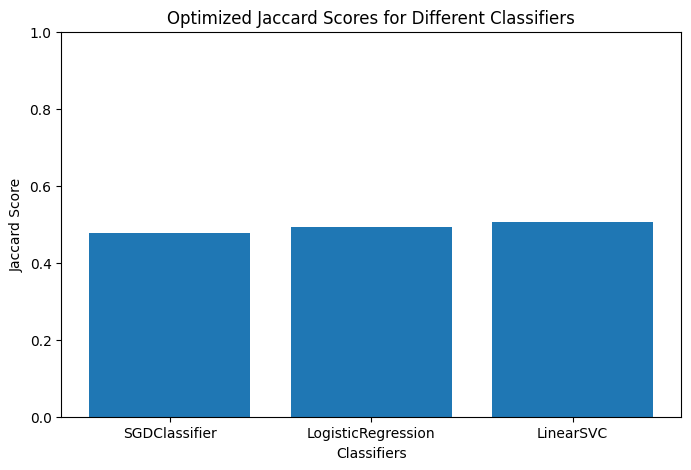

In [5]:
# hyperparameter grids
param_grids = {
    'SGDClassifier': {
        'estimator__loss': ['hinge', 'log_loss', 'modified_huber'],
        'estimator__alpha': [0.0001, 0.001, 0.01],
        'estimator__max_iter': [1000, 5000, 10000],
    },
    'LogisticRegression': {
        'estimator__C': [0.1, 1, 10],
        'estimator__penalty': ['l1'],  
        'estimator__solver': ['liblinear'],  # 'lbfgs' for 'l2'
    },
    'LinearSVC': {
        'estimator__C': [1, 1.5, 10],
        'estimator__penalty': ['l2', 'l1'],
        'estimator__max_iter': [10000],
    }
}

# classifiers
classifiers = {
    'SGDClassifier': SGDClassifier(),
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC(dual=False)
}

# RandomizedSearchCV for each classifier
scores = []
for name, classifier in classifiers.items():
    print(f"Optimizing {name}...")
    clf = OneVsRestClassifier(classifier)
    param_grid = param_grids[name]
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        n_iter=10,
        scoring='jaccard_samples', 
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        error_score=np.nan  
    )
    random_search.fit(X_train_tfidf, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)
    score = jaccard_score(y_test, y_pred, average='samples', zero_division=0)
    scores.append((name, score))
    print(f"Best params for {name}: {random_search.best_params_}")
    print(f"Best Jaccard score: {score}")

# Extract names and Jaccard scores
names, jaccard_scores = zip(*scores)

plt.figure(figsize=(8, 5))
plt.bar(names, jaccard_scores)
plt.title('Optimized Jaccard Scores for Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('Jaccard Score')
plt.ylim(0, 1)
plt.show()

### 5.2 RandomizedSearchCV for TDIDF parameters

In [6]:
# Function to evaluate parameters
def evaluate_tfidf_and_model(X_train, X_test, y_train, y_test):
    # parameter grid for TF-IDF
    param_grid = {
        'tfidf__max_features': [8000, 10000],
        'tfidf__max_df': [0.4, 0.5, 0.9],
        'tfidf__min_df': [5, 10, 50],
        'tfidf__ngram_range': [(1, 1), (1, 2)],        
    }

    # Define pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer)),
        ('svc', OneVsRestClassifier(LinearSVC(dual='auto', C=1.5, penalty='l1', max_iter=10000))),
    ])

    # Grid search with cross-validation
    grid_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,  
    n_iter=30,                       
    scoring='jaccard_samples',
    cv=3,
    verbose=3,
    n_jobs=-1
)
    grid_search.fit(X_train, y_train)

    # best parameters
    print("Best Parameters:", grid_search.best_params_)
    print("Best Jaccard Score:", grid_search.best_score_)

    # Test on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Test Jaccard Score:", jaccard_score(y_test, y_pred, average='samples', zero_division=0))

evaluate_tfidf_and_model(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'tfidf__max_features': 10000, 'tfidf__max_df': 0.5}
Best Jaccard Score: 0.47045976005274365
Test Jaccard Score: 0.4818091168091168


## 6. Inference

In [26]:
# Test input text
test_text = 'convert decimal double c# want assign decimal variable trans double variable opacity decimal trans trackbar value opacity trans build app give follow error cannot implicitly convert type decimal double'

# Preprocess the input text (same as during training)
test_text_cleaned = custom_tokenizer(test_text)  # Clean and tokenize the input
test_text_str = ' '.join(test_text_cleaned)  # Convert list of words to string

# Transform the input text using the same TfidfVectorizer
test_text_tfidf = tfidf.transform([test_text_str])

# Predict the tags using the model
predicted_tags = clf.predict(test_text_tfidf)

# print("Shape of predicted_tags:", predicted_tags.shape)
# print("Predicted tags (raw binary vector):", predicted_tags[0])

predicted_tag_names = [top_tags[i] for i in range(len(predicted_tags[0])) if predicted_tags[0][i] == 1]

print("Predicted Tag Names:", predicted_tag_names)


Predicted Tag Names: ['c#']


In [27]:
tokens = tfidf.build_analyzer()(test_text_str)
print("Tokens generated by TfidfVectorizer:", tokens)

decision_scores = clf.decision_function(test_text_tfidf)
for tag, score in zip(top_tags, decision_scores[0]):
    print(f"{tag}: {score:.4f}")

Tokens generated by TfidfVectorizer: ['convert', 'decimal', 'double', 'c#', 'want', 'assign', 'decimal', 'variable', 'trans', 'double', 'variable', 'opacity', 'decimal', 'trans', 'trackbar', 'value', 'opacity', 'trans', 'build', 'app', 'give', 'follow', 'error', 'implicitly', 'convert', 'type', 'decimal', 'double', 'convert decimal', 'decimal double', 'double c#', 'c# want', 'want assign', 'assign decimal', 'decimal variable', 'variable trans', 'trans double', 'double variable', 'variable opacity', 'opacity decimal', 'decimal trans', 'trans trackbar', 'trackbar value', 'value opacity', 'opacity trans', 'trans build', 'build app', 'app give', 'give follow', 'follow error', 'error implicitly', 'implicitly convert', 'convert type', 'type decimal', 'decimal double']
c#: 1.1576
java: -0.7242
c++: -0.9785
javascript: -0.9794
php: -1.9856
asp.net: -1.5174
jquery: -1.5100
iphone: -1.0811
python: -1.7775
sql: -1.7292
html: -1.7825
sql-server: -1.7640
objective-c: -1.6698
mysql: -1.2279
windows:

## 7. MLFlow

In [20]:
# Define models to test
models = {
    "LogisticRegression": LogisticRegression(solver= 'liblinear', penalty= 'l1', C= 10),
    "SGDClassifier": SGDClassifier(loss= 'modified_huber', alpha= 0.0001 ,max_iter=10000),    
    "LinearSVC": LinearSVC(dual='auto', C=1.5, penalty='l1', max_iter=10000)
}

# Start a new MLFlow experiment
mlflow.set_tracking_uri("file:///c:/Users/Luciana/Documents/GitHub/NLP-Multi-Label-Text-Classification-for-Stack-Overflow-Tag-Prediction/mlruns")
mlflow.set_experiment("Tag Suggestion Classification v2")
print("Experiment set: Tag Suggestion Classification v2")

input_example = X_train_tfidf[0:1]

# Iterate over models with a progress bar
for model_name, model in tqdm(models.items(), desc="Training models"):
    print(f"Starting run for {model_name}...")
    
    with mlflow.start_run(run_name=f"{model_name}_OneVsRest"):
        
        # Create the pipeline with OneVsRestClassifier
        pipeline = Pipeline([
            ('classifier', OneVsRestClassifier(model))
        ])

        # Log hyperparameters
        mlflow.log_param("model_name", model_name)
        
        # Measure training time
        start_time = time.time()
        
        # Train the model
        pipeline.fit(X_train_tfidf, y_train)
        
        # Calculate training time
        training_time = time.time() - start_time
        mlflow.log_metric("training_time", training_time)
        
        # Predict and calculate Jaccard score
        y_pred = pipeline.predict(X_test_tfidf)
        jaccard = jaccard_score(y_test, y_pred, average='samples', zero_division=0)
        
        # Log the Jaccard score
        mlflow.log_metric("jaccard_score", jaccard)
        print(f"Logging model: {model_name}, Jaccard score: {jaccard}")
        
        # Log the trained model
        mlflow.sklearn.log_model(pipeline, artifact_path=f"models/{model_name}", input_example=input_example)

        # Output the model's Jaccard score
        print(f"Model {model_name} - Jaccard Score: {jaccard}")

Experiment set: Tag Suggestion Classification v2


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Starting run for LogisticRegression...
Logging model: LogisticRegression, Jaccard score: 0.4929754273504274


Training models:  33%|███▎      | 1/3 [00:42<01:25, 42.85s/it]

Model LogisticRegression - Jaccard Score: 0.4929754273504274
Starting run for SGDClassifier...
Logging model: SGDClassifier, Jaccard score: 0.47693172568172576


Training models:  67%|██████▋   | 2/3 [00:53<00:23, 23.90s/it]

Model SGDClassifier - Jaccard Score: 0.47693172568172576
Starting run for LinearSVC...
Logging model: LinearSVC, Jaccard score: 0.5056649369149369


Training models: 100%|██████████| 3/3 [02:17<00:00, 45.96s/it]

Model LinearSVC - Jaccard Score: 0.5056649369149369


## 8. Analyse de stabilité mensuelle

In [12]:
# Analyse de stabilité mensuelle
for month in range(1, 13):
    with mlflow.start_run(run_name=f"Stability_Test_Month_{month}"):
        
        # Partition du dataset pour chaque mois
        X_test_month, _, y_test_month, _ = train_test_split(X_test_tfidf, y_test, test_size=0.8, random_state=month)

        # Prédiction 
        y_pred_month = pipeline.predict(X_test_month)

        # Calcul du jaccard score pour le mois spécifique
        jaccard_month = jaccard_score(y_test_month, y_pred_month, average='samples', zero_division=0)

        # Logging des résultats
        mlflow.log_param("month", month)
        mlflow.log_metric("jaccard_score_monthly", jaccard_month)
        
        print(f"Month {month} - Jaccard Score: {jaccard_month}")

Month 1 - Jaccard Score: 0.5094932844932845
Month 2 - Jaccard Score: 0.49258496133496127
Month 3 - Jaccard Score: 0.5011319698819698
Month 4 - Jaccard Score: 0.4881995319495319
Month 5 - Jaccard Score: 0.5297568172568172
Month 6 - Jaccard Score: 0.4929588929588929
Month 7 - Jaccard Score: 0.5068910256410256
Month 8 - Jaccard Score: 0.49528133903133903
Month 9 - Jaccard Score: 0.502241045991046
Month 10 - Jaccard Score: 0.5242165242165242
Month 11 - Jaccard Score: 0.49351088726088727
Month 12 - Jaccard Score: 0.498756105006105
